In [2]:
include("./src/gravity-tools.jl")
include("./src/trade-environment.jl")
using CSV
using DataFrames
using Plots
using MINPACK

## Step 1 Bulid the Eaton and Kortum (2002) dataset

Honestly, this came from my MATLAB code as a PHD student. The issue now is the Econometrica replication files are in GAUSS...

In [3]:
################################################################
# builds the EK dataset

dftrade = DataFrame(CSV.File("./ek-data/ek-data.csv"))

dflang = DataFrame(CSV.File("./ek-data/ek-language.csv"))

dflabor = DataFrame(CSV.File("./ek-data/ek-labor.csv"))

filter!(row -> ~(row.trade ≈ 1.0), dftrade);

filter!(row -> ~(row.trade ≈ 0.0), dftrade);

dftrade = hcat(dftrade, dflang);

#dfcntryfix = select(dftrade,Not("trade"))
dfcntryfix = DataFrame(CSV.File("./ek-data/ek-cntryfix.csv"));

Then this code makes a ``gravity_parameters`` structure that is used in the computation of the model

In [4]:
grv_params = gravity_params(L = dflabor.L, dfcntryfix = dfcntryfix)

gravity_params
  Ncntry: Int64 19
  θ: Float64 4.0
  L: Array{Float64}((19,)) [0.054, 0.024, 0.029, 0.094, 0.017, 0.019, 0.181, 0.0225, 0.025, 0.159, 0.544, 0.043, 0.01, 0.015, 0.026, 0.1, 0.031, 0.186, 1.0]
  dfcntryfix: DataFrame


## Step 2

This runs the "Gravity Regression" (equation (28)) with the trade cost specification in equation (29). 

The function ``gravity`` runs a Fixed Effect Model (using that package in Julia) and then normalizes the coefficients per Eaton and Kortum's normalization (see footnote of Table III). 

The output ``grvdata`` is a structure with the estimated coefficients.

In [5]:
grvdata = gravity(dftrade, display = true);


                            Fixed Effect Model                            
Number of obs:                   342  Degrees of freedom:                8
R2:                            0.976  R2 Adjusted:                   0.972
F-Stat:                      87.9716  p-value:                       0.000
R2 within:                     0.729  Iterations:                        4
trade          |  Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
--------------------------------------------------------------------------
bin375         |   3.45649  0.204755  16.8811    0.000   3.05353   3.85946
bin750         |   2.89299  0.167308  17.2914    0.000   2.56372   3.22226
bin1500        |   2.52554  0.156294  16.1589    0.000   2.21795   2.83313
bin3000        |   2.34086   0.20072  11.6623    0.000   1.94583   2.73588
bin6000        |  0.494561  0.121258  4.07857    0.000   0.25592  0.733202
binmax         |       0.0       NaN      NaN      NaN       NaN       NaN
border         |  0.30356

## Step 3

This next step recovers the primitives from the gravity coeffecients. Each function does what it says...gets the trade costs, gets the technology term. And all this is given a $\theta$. 

In [6]:
# ################################################################
# # Recover the trade costs and technology parameters

θ = 4.0

d = zeros(19,19)
T = zeros(19)
W = ones(19)

make_trade_costs!(grvdata, d, grv_params)

make_technology!(grvdata, T, W, grv_params)

## Step 4

Here I construct the pattern of trade (the $\pi$'s) given the primitives. Then I test if I run the gravity regression on the model generated data, do I get back what I fed into it. I do.

In [7]:
@time πshares, Φ = eaton_kortum(W, d, T, θ)

# Now re-run the gravity regression on the model to 
# see if we recover the proper coeffecients

trademodel = log.(vec(normalize_by_home_trade(πshares, grv_params.Ncntry)'))

dfmodel = DataFrame(trade = trademodel)

filter!(row -> ~(row.trade ≈ 1.0), dfmodel);

filter!(row -> ~(row.trade ≈ 0.0), dfmodel);

dfmodel = hcat(dfmodel, dfcntryfix)

grv = gravity(dfmodel, display = true);

  0.140552 seconds (201.64 k allocations: 10.259 MiB, 15.91% gc time, 99.95% compilation time)
                              Fixed Effect Model                              
Number of obs:                     342  Degrees of freedom:                  8
R2:                              1.000  R2 Adjusted:                     1.000
F-Stat:                     1.41798e31  p-value:                         0.000
R2 within:                       1.000  Iterations:                          4
trade          |  Estimate   Std.Error    t value Pr(>|t|) Lower 95% Upper 95%
------------------------------------------------------------------------------
bin375         |   3.45649 5.09999e-16 6.77745e15    0.000   3.45649   3.45649
bin750         |   2.89299 4.16728e-16 6.94216e15    0.000   2.89299   2.89299
bin1500        |   2.52554 3.89294e-16 6.48749e15    0.000   2.52554   2.52554
bin3000        |   2.34086 4.99949e-16 4.68219e15    0.000   2.34086   2.34086
bin6000        |  0.494561 3.02028e-

## Step 5

Let's visualize the model's prediction against the data.

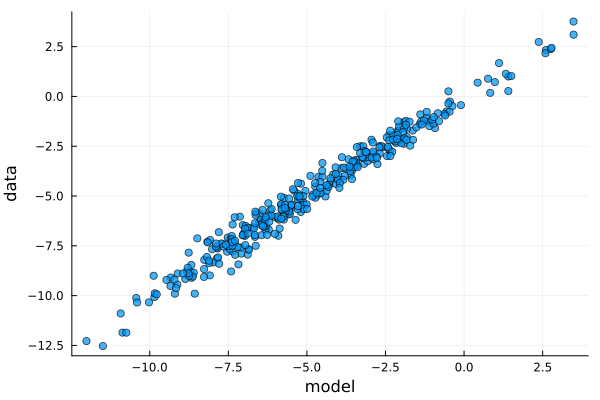

In [8]:
plot(dfmodel.trade, dftrade.trade, seriestype = :scatter, alpha = 0.75,
    xlabel = "model",
    ylabel = "data",
    legend = false)

## Bonus: Waugh (2010) trade cost formulation

The trick here is that the gravity regression is exactly the same. However, the fixed effects have a different interpretation. So the exporter effect is a combination of both technology and a trade cost effect that shits them up or down depending upon the identity of the exporter. And then the importer effect is purely about technology. Where as Eaton and Kortum (2002) does the opposite.  

In [9]:
trade_cost_type = "waugh"

grvdata = gravity(dftrade, trade_cost_type = trade_cost_type, display = true);

trc = trade_costs(grvdata.dist_coef, grvdata.lang_coef, grvdata.θm)

                            Fixed Effect Model                            
Number of obs:                   342  Degrees of freedom:                8
R2:                            0.976  R2 Adjusted:                   0.972
F-Stat:                      87.9716  p-value:                       0.000
R2 within:                     0.729  Iterations:                        4
trade          |  Estimate Std.Error  t value Pr(>|t|) Lower 95% Upper 95%
--------------------------------------------------------------------------
bin375         |   3.45649  0.204755  16.8811    0.000   3.05353   3.85946
bin750         |   2.89299  0.167308  17.2914    0.000   2.56372   3.22226
bin1500        |   2.52554  0.156294  16.1589    0.000   2.21795   2.83313
bin3000        |   2.34086   0.20072  11.6623    0.000   1.94583   2.73588
bin6000        |  0.494561  0.121258  4.07857    0.000   0.25592  0.733202
binmax         |       0.0       NaN      NaN      NaN       NaN       NaN
border         |  0.30356

trade_costs{Float64}([-3.10244015102019, -3.665940509065174, -4.033395393515958, -4.218077290075895, -6.064372105694247, -6.558933104672114], [0.3035635616222773, 0.510080412962132, 0.03591185436242707, 0.5360709251406857], [0.23622064966064826, -1.6784149804992956, 1.120118200623811, 0.688595775215314, -0.5058894995743253, -1.3344877788549492, 0.21829436972446947, 0.9988122648863524, -2.3564109696351037, 0.0701778640858477, 1.5848898701604295, 1.0047821555108039, 0.06657359083711833, -1.0004088010629988, -1.2067802787609305, -1.1566113535553866, -0.02486437399882835, 0.8168075200216955, 2.458595775215313])

So here notice that the exporter effect takes the same value as the destination effect. But notice that the source effect is different. In particular, the sum of the exporter + source is the original source effect in Eaton and Kortum (2002)

Now let's test the code... reconstruct trade costs and technology, pass them to the model, run the gravity regression on model generated data...

In [10]:
d = zeros(19,19)

make_trade_costs!(grvdata, d, grv_params, trade_cost_type = trade_cost_type)

T = zeros(19)
W = ones(19)

make_technology!(grvdata, T, W, grv_params)

@time πshares, Φ = eaton_kortum(W, d, T, grv_params.θ)

# Now re-run the gravity regression on the model to 
# see if we recover the proper coeffecients

trademodel = log.(vec(normalize_by_home_trade(πshares, grv_params.Ncntry)'))

dfmodel = DataFrame(trade = trademodel)

filter!(row -> ~(row.trade ≈ 1.0), dfmodel);

filter!(row -> ~(row.trade ≈ 0.0), dfmodel);

dfmodel = hcat(dfmodel, dfcntryfix)

grv = gravity(dfmodel, trade_cost_type = trade_cost_type, display = true);



  0.000039 seconds (64 allocations: 14.953 KiB)
                              Fixed Effect Model                              
Number of obs:                     342  Degrees of freedom:                  8
R2:                              1.000  R2 Adjusted:                     1.000
F-Stat:                     1.72351e31  p-value:                         0.000
R2 within:                       1.000  Iterations:                          4
trade          |  Estimate   Std.Error    t value Pr(>|t|) Lower 95% Upper 95%
------------------------------------------------------------------------------
bin375         |   3.45649 4.62593e-16   7.472e15    0.000   3.45649   3.45649
bin750         |   2.89299 3.77992e-16 7.65358e15    0.000   2.89299   2.89299
bin1500        |   2.52554 3.53107e-16 7.15232e15    0.000   2.52554   2.52554
bin3000        |   2.34086 4.53477e-16 5.16202e15    0.000   2.34086   2.34086
bin6000        |  0.494561 2.73953e-16 1.80528e15    0.000  0.494561  0.494561
binm

Then notice how things are replicated...

And then the plot test.

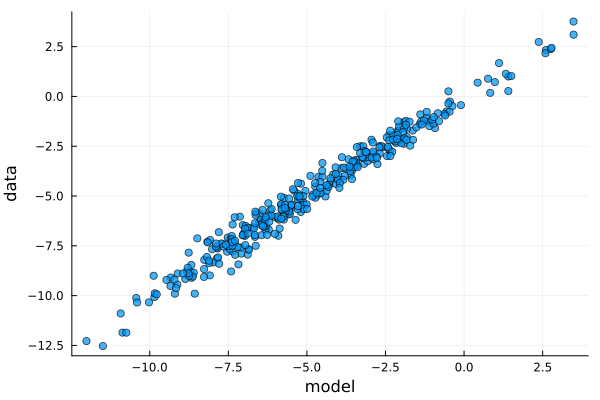

In [11]:
plot(dfmodel.trade, dftrade.trade, seriestype = :scatter, alpha = 0.75,
    xlabel = "model",
    ylabel = "data",
    legend = false)